In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
! pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl -q
! pip install git+https://github.com/huggingface/accelerate -q

     |████████████████████████████████| 149.9 MB 87 kB/s 
     |████████████████████████████████| 57 kB 2.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.278 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [4]:
!pip install accelerate -q

In [5]:
from accelerate import Accelerator
acc = Accelerator()
acc.device
# acc.device

device(type='xla', index=1)

In [6]:
!pip install hazm -q
!pip install accelerate -q
!pip install datasets -q
!pip install transformers -q
!pip install -q clean-text[gpl]
!pip install sentencepiece -q

     |████████████████████████████████| 316 kB 5.5 MB/s 
     |████████████████████████████████| 233 kB 44.2 MB/s 
     |████████████████████████████████| 1.4 MB 44.3 MB/s 
     |████████████████████████████████| 264 kB 5.4 MB/s 
     |████████████████████████████████| 118 kB 56.5 MB/s 
     |████████████████████████████████| 243 kB 48.9 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 2.6 MB 5.5 MB/s 
     |████████████████████████████████| 3.3 MB 49.5 MB/s 
     |████████████████████████████████| 636 kB 57.1 MB/s 
     |████████████████████████████████| 895 kB 61.4 MB/s 
     |████████████████████████████████| 184 kB 5.3 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 241 kB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 5.2 MB/s 


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse

import torch
from torch.utils.data import DataLoader

from accelerate import Accelerator, DistributedType
from datasets import load_dataset, load_metric
from transformers import (
    AdamW,
    AutoModelForSequenceClassification,
    RobertaForSequenceClassification,
    AutoTokenizer,
    XLMRobertaTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.utils import shuffle

import hazm
from cleantext import clean

import plotly.express as px
import plotly.graph_objects as go

from tqdm.notebook import tqdm

import os
import sys
import re
import json
import copy
import collections

In [11]:
train_data = pd.read_csv('/content/gdrive/MyDrive/UT/Divar Summer Camp/Q2/train_set.csv')
train_data.head()

,app_id,description_fa,label
0,0,<p>بازی مین روب یک برنامه فکری است که باید مین...,1
1,1,<p>دراین بازی تعدادی عکس برای شما نشان داده می...,1
2,2,<br>تلاش نافرجام برای درک «بوفالو»<br>مرگ پایا...,7
3,3,<p>فیلم نما ، برنامه ای برای دانلود و پخش آنلا...,7
4,4,<p>* این برنامه حاوی بیش از 500 عکس و ژست برای...,7


In [12]:
test_data = pd.read_csv('/content/gdrive/MyDrive/UT/Divar Summer Camp/Q2/test_set.csv')
test_data.head()

,app_id,description_fa
0,40000,<h4>در این برنامه یکی از بازی های جالب میکرو ر...
1,40001,<p>بازی آموزشی میلونر زبان انگلیسی برای تقویت ...
2,40002,<p> <b>موضوع رو می بینی و کلمات رو پیدا می کنی...
3,40003,<p>نرم افزار فول تلگرام در کنار تلگرام امكانات...
4,40004,<p> فکر می کنی خیلی سریع هستی نه؟ <br> ...


In [10]:
train_data = train_data.sample(frac=1).reset_index(drop=True)

In [ ]:
classes = train_data['label'].unique()
classes

array([4, 2, 6, 3, 1, 5, 7, 9, 8, 0])

In [ ]:
def get_brand_distribution(data):
    class_number = {}
    classes = data['label'].unique()
    for c in classes:
        class_number[c] = sum(data['label'] == c)
    
    plt.bar(class_number.keys(), class_number.values())
    plt.xticks(rotation = 90)
    plt.xlabel('class')
    plt.ylabel('number of app in the class')
    plt.title('Distribution of apps')
    plt.show()

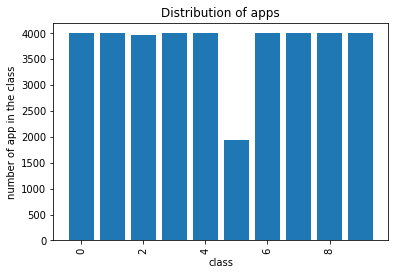

In [ ]:
get_brand_distribution(train_data)

## Cleaning the data

In [ ]:
from nltk.tokenize import RegexpTokenizer
import re

In [ ]:
def clean_html(raw_html):
    cleanr = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6}|\[a-z0-9]);')
    clean_text = re.sub(cleanr, '', raw_html)
    delete_num = r'[0-9]'
    clean_text = re.sub(delete_num, '', clean_text)
    clean_text = re.sub(r'http\S+', '', clean_text)
    clean_text = re.sub(r'[a-z]', '', clean_text)
    # removing extra spaces, hashtags
    clean_text = re.sub("#", "", clean_text)
    clean_text = re.sub("\s+", " ", clean_text)
    clean_text = ' '.join(clean_text.split())
    clean_text = clean(clean_text,
        fix_unicode=True,
        to_ascii=False,
        lower=True,
        no_line_breaks=True,
        no_urls=True,
        no_emails=True,
        no_phone_numbers=True,
        no_numbers=False,
        no_digits=False,
        no_currency_symbols=True,
        no_punct=False,
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="0",
        replace_with_currency_symbol="",
    )
    return clean_text

In [ ]:
train_data['description_fa'] = train_data['description_fa'].apply(lambda x : clean_html(x))

In [ ]:
train_data['description_fa']

0        یکی دیگر از بازی های بتمن سگا که میتوانید بتمن...
1        در این بازی کنترل پسر بچه ای رو در دست دارید ک...
2        * بازی وینینگ الون جدید برای اندروید* * با حضو...
3        داستان بازی در سال ۲۰۲۸ روایت می‌شود که بسیاری...
4        در این بازی بازی بوکس حیوانات قوی شما خود را ب...
                               ...                        
37894    یک بازی فکری برای تمام سنین. شامل مرحله است که...
37895    بازی پپسی من یک بازی خارق العاده است که بیشتر ...
37896    با اپلیکیشن وکیل رایگان به تمام مطالب حقوقی به...
37897    با اين برنامه به راحتي مي توانيد عکس هاتون رو ...
37898    تغییر پس زمینه بصورت خودکاربا برنامه حذف و تغی...
Name: description_fa, Length: 37899, dtype: object

In [ ]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [ ]:
train_data['description_fa'] = train_data['description_fa'].apply(lambda x : deEmojify(x))
train_data['description_fa']

0        یکی دیگر از بازی های بتمن سگا که میتوانید بتمن...
1        در این بازی کنترل پسر بچه ای رو در دست دارید ک...
2        * بازی وینینگ الون جدید برای اندروید* * با حضو...
3        داستان بازی در سال ۲۰۲۸ روایت می‌شود که بسیاری...
4        در این بازی بازی بوکس حیوانات قوی شما خود را ب...
                               ...                        
37894    یک بازی فکری برای تمام سنین. شامل مرحله است که...
37895    بازی پپسی من یک بازی خارق العاده است که بیشتر ...
37896    با اپلیکیشن وکیل رایگان به تمام مطالب حقوقی به...
37897    با اين برنامه به راحتي مي توانيد عکس هاتون رو ...
37898    تغییر پس زمینه بصورت خودکاربا برنامه حذف و تغی...
Name: description_fa, Length: 37899, dtype: object

In [ ]:
def punctuation_remover(sentence):
    sentence = re.sub(r'[^\w\s]','',sentence) #remove everything except words and space
    sentence = re.sub(r'_','', sentence) #how to remove underscore as well
    return ' '.join(sentence.split())

In [ ]:
train_data['description_fa'] = train_data['description_fa'].apply(lambda x : punctuation_remover(x))
train_data['description_fa']

0        یکی دیگر از بازی های بتمن سگا که میتوانید بتمن...
1        در این بازی کنترل پسر بچه ای رو در دست دارید ک...
2        بازی وینینگ الون جدید برای اندروید با حضور تیم...
3        داستان بازی در سال ۲۰۲۸ روایت میشود که بسیاری ...
4        در این بازی بازی بوکس حیوانات قوی شما خود را ب...
                               ...                        
37894    یک بازی فکری برای تمام سنین شامل مرحله است که ...
37895    بازی پپسی من یک بازی خارق العاده است که بیشتر ...
37896    با اپلیکیشن وکیل رایگان به تمام مطالب حقوقی به...
37897    با اين برنامه به راحتي مي توانيد عکس هاتون رو ...
37898    تغییر پس زمینه بصورت خودکاربا برنامه حذف و تغی...
Name: description_fa, Length: 37899, dtype: object

# Train Test Split

In [ ]:
X = train_data.drop(columns=['label'])
y = train_data['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **XLM-R** finetuning

In [ ]:
MAX_GPU_BATCH_SIZE = 16
EVAL_BATCH_SIZE = 16

# MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased'
MODEL_NAME_OR_PATH = 'xlm-roberta-base'
OUTPUT_PATH = '/content/pytorch_model.bin'
MODEL_SAVE_DIRECTORY = '/content/gdrive/MyDrive/UT/Divar Summer Camp/Q1/model'

In [ ]:
class DivarDataset(torch.utils.data.Dataset):
    """ Create a PyTorch dataset for Taaghche. """

    def __init__(self, tokenizer, descriptions, targets=None, label_list=None, max_len=128):
        self.descriptions = descriptions
        self.targets = targets
        self.has_target = isinstance(targets, list) or isinstance(targets, np.ndarray)

        self.tokenizer = tokenizer
        self.max_len = max_len

        
        self.label_map = {label: i for i, label in enumerate(label_list)} if isinstance(label_list, list) else {}
        # print(label_map)
    
    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, item):
        description = str(self.descriptions[item])

        if self.has_target:
            target = self.label_map.get((self.targets[item]), (self.targets[item]))

        encoding = self.tokenizer.encode_plus(
            description,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')
        
        inputs = {
            # 'description': description,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            # 'token_type_ids': encoding['token_type_ids'].flatten(),
        }

        if self.has_target:
            inputs['labels'] = torch.tensor(target, dtype=torch.long)
        
        return inputs


def create_data_loader(x, y, tokenizer, max_len, batch_size, label_list):
    dataset = DivarDataset(
        descriptions=x,
        targets=y,
        tokenizer=tokenizer,
        max_len=max_len, 
        label_list=label_list)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
def training_function(config, args = None):
    accelerator = Accelerator()
    print(f"device : {accelerator.device}")
    print(f'{accelerator.is_main_process}')

    lr = config["lr"]
    num_epochs = int(config["num_epochs"])
    correct_bias = config["correct_bias"]
    seed = int(config["seed"])
    batch_size = int(config["batch_size"])

    tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
    dataset_train = DivarDataset(tokenizer, X_train['description_fa'].to_numpy(), y_train.to_numpy(), label_list=classes, max_len=360)
    dataset_valid = DivarDataset(tokenizer, X_valid['description_fa'].to_numpy(), y_valid.to_numpy(), label_list=classes, max_len=360)
    metric = load_metric("f1")

    gradient_accumulation_steps = 1
    if batch_size > MAX_GPU_BATCH_SIZE:
        gradient_accumulation_steps = batch_size // MAX_GPU_BATCH_SIZE
        batch_size = MAX_GPU_BATCH_SIZE

    def collate_fn(examples):
        if accelerator.distributed_type == DistributedType.TPU:
            return tokenizer.pad(examples, padding="max_length", max_length=360, return_tensors="pt")
        return tokenizer.pad(examples, padding="longest", return_tensors="pt")

    train_dataloader = DataLoader(
        dataset_train, shuffle=True, collate_fn=collate_fn, batch_size=batch_size
    )
    eval_dataloader = DataLoader(
        dataset_valid, shuffle=False, collate_fn=collate_fn, batch_size=EVAL_BATCH_SIZE
    )

    set_seed(seed)

    model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, num_labels=10, return_dict=True)

    model = model.to(accelerator.device)

    optimizer = AdamW(params=model.parameters(), lr=lr, correct_bias=correct_bias)

    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )

    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=100,
        num_training_steps=len(train_dataloader) * num_epochs,
    )

    train_loader_len = len(train_dataloader)
    eval_loader_len = len(eval_dataloader)

    best_score = 0
    for epoch in range(num_epochs):
        model.train()
        tk0 = tqdm(train_dataloader, total=train_loader_len, disable=not accelerator.is_local_main_process, file=sys.stdout)
        counter, running_loss = 0, 0
        for step, batch in enumerate(tk0):
            batch.to(accelerator.device)
            outputs = model(**batch)
            loss = outputs.loss
            running_loss += loss.item() #* inputs.size(0)
            loss = loss / gradient_accumulation_steps
            counter += 1
            accelerator.backward(loss)
            if step % gradient_accumulation_steps == 0:
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            tk0.set_postfix(loss=(running_loss / counter))

        pred_list, target_list = [], []
        model.eval()
        tk1 = tqdm(eval_dataloader, total=eval_loader_len, disable=not accelerator.is_local_main_process, file=sys.stdout)
        for step, batch in enumerate(tk1):
            batch.to(accelerator.device)
            with torch.no_grad():
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)
            pred_list.append(accelerator.gather(predictions))
            target_list.append(accelerator.gather(batch["labels"]))


        pred_np = torch.cat(pred_list, dim=0).detach().cpu().numpy()
        target_np = torch.cat(target_list, dim=0).detach().cpu().numpy()

        eval_metric = balanced_accuracy_score(target_np, pred_np)
        accelerator.print(f"balanced accuracy for epoch {epoch}:", eval_metric)
        if eval_metric > best_score:
            accelerator.print(f'new best model found. saving...')
            model.save_pretrained(MODEL_SAVE_DIRECTORY)


In [ ]:

config = {"lr": 2e-5, "num_epochs": 5, "correct_bias": True, "seed": 42, "batch_size": 16}
training_function(config)

device : xla:1
True


You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights o


balanced accuracy for epoch 0: 0.7138629790381601
new best model found. saving...



balanced accuracy for epoch 1: 0.7556180687931546
new best model found. saving...



balanced accuracy for epoch 2: 0.756444187838679
new best model found. saving...



balanced accuracy for epoch 3: 0.7590836424821843
new best model found. saving...



balanced accuracy for epoch 4: 0.7633778389558508
new best model found. saving...


In [ ]:
model = RobertaForSequenceClassification.from_pretrained(MODEL_SAVE_DIRECTORY, num_labels=10, return_dict=True)

In [ ]:
model.eval()

# Clean and prepare test data

In [ ]:
test_data['description_fa'] = test_data['description_fa'].apply(lambda x : clean_html(x))
test_data['description_fa'] = test_data['description_fa'].apply(lambda x : deEmojify(x))
test_data['description_fa'] = test_data['description_fa'].apply(lambda x : punctuation_remover(x))
test_data['description_fa']

0       در این برنامه یکی از بازی های جالب میکرو را بر...
1       بازی آموزشی میلونر زبان انگلیسی برای تقویت زبا...
2       موضوع رو می بینی و کلمات رو پیدا می کنی شاد و ...
3       نرم افزار فول تلگرام در کنار تلگرام امكاناتي ر...
4       فکر می کنی خیلی سریع هستی نه می تونی خودتو امت...
                              ...                        
9995    فالوورگیر اینستاگرام با امکانات لایک بگیر اینس...
9996    میخوای نامحدود آنفلو کنی دلتون مي خواد عكسهای ...
9997    یک بازی زیبا از کنسول میکرو به یاد گذشته براتو...
9998    دوست داری اطلاعات عمومی بالایی داشته باشی دوست...
9999    لباس چند تا تیم فوتبالو میشناسی دلت میخواد خود...
Name: description_fa, Length: 10000, dtype: object

# Predict test

In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME_OR_PATH)
def collate_fn(examples):
    if accelerator.distributed_type == DistributedType.TPU:
        return tokenizer.pad(examples, padding="max_length", max_length=360, return_tensors="pt")
    return tokenizer.pad(examples, padding="longest", return_tensors="pt")

accelerator = Accelerator()


dataset_test = DivarDataset(tokenizer, test_data['description_fa'].to_numpy(), label_list=classes, max_len=360)
test_dataloader = DataLoader(
        dataset_test, shuffle=False, collate_fn=collate_fn, batch_size=EVAL_BATCH_SIZE
)

model = model.to(accelerator.device)

model, test_dataloader = accelerator.prepare(
    model, test_dataloader
)

pred_list = []
tk1 = tqdm(test_dataloader, total=len(test_dataloader), disable=not accelerator.is_local_main_process, file=sys.stdout)
for step, batch in enumerate(tk1):
    batch.to(accelerator.device)
    with torch.no_grad():
        outputs = model(**batch)
    predictions = outputs.logits.argmax(dim=-1)
    pred_list.append(accelerator.gather(predictions))

pred_np = torch.cat(pred_list, dim=0).detach().cpu().numpy()

In [ ]:
test_data['label'] = pred_np.tolist()
res = test_data.drop(columns=['description_fa'])
res.to_csv('prediction.csv', index=False)

--------------------------------------------------------------------------------